In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

from glob import glob
import re
import os


In [11]:
# 小数点以下n桁表示
pd.options.display.float_format = '{:.2f}'.format

In [12]:
csv_files = glob('../csv/EXA_FIRST_マイジャグラーV_*.csv')
len(csv_files), csv_files[0]

(326, '../csv\\EXA_FIRST_マイジャグラーV_2024-05-01.csv')

In [13]:
def extract_information(csv_file):
    pattern = r"(.+)_(.+)_(\d{4}-\d{2}-\d{2}).csv"

    file_name = os.path.basename(csv_file)
    # print(file_name)
    match = re.match(pattern, file_name)

    if match:
        hall_name, machine_name, date_str = match.groups()
        return hall_name, machine_name, date_str
    else:
        print(f"ファイル名の形式が一致しません {file_name}")
        print(f"ホール名: {hall_name}")
        print(f"機種名: {machine_name}")
        print(f"日付: {date_str}")

In [14]:
def calc_grape_rate(game_count, bb_count, rb_count, coins):
    bb_coins = 240
    rb_coins = 96
    cherry_coins = 2
    cherry_rate = 38.1
    replay_coins = 3
    replay_rate = 7.3
    grape_coins = 8

    in_coins = game_count * 3

    out_with_cherry = (
        bb_coins * bb_count
        + rb_coins * rb_count
        + (cherry_coins * game_count / cherry_rate)
        + (replay_coins * game_count / replay_rate)
    )
    without_cherry_rate = 0.667
    out_without_cherry = (
        bb_coins * bb_count
        + rb_coins * rb_count
        + (cherry_coins * game_count / cherry_rate * without_cherry_rate)
        + (replay_coins * game_count / replay_rate)
    )

    grape_rate_with_cherry = (
        grape_coins * game_count / (coins + in_coins - out_with_cherry)
    )
    grape_rate_without_cherry = (
        grape_coins * game_count / (coins + in_coins - out_without_cherry)
    )

    # print("フリー打ち : ", grape_rate_without_cherry)
    # print("チェリー狙い : ", grape_rate_with_cherry)
    
    return grape_rate_with_cherry, grape_rate_without_cherry


def calc_total_coins(game_count, bb_count, rb_count, grape_rate=5.9):

    BB_COINS = 240
    RB_COINS = 96
    CHERRY_COINS = 2
    CHERRY_RATE = 38.1
    REPLAY_COINS = 3
    REPLAY_RATE = 7.3
    GRAPE_COINS = 8

    in_coins = game_count * 3

    out_coins = sum([
        BB_COINS * bb_count,
        RB_COINS * rb_count,
        CHERRY_COINS * game_count / CHERRY_RATE,
        REPLAY_COINS * game_count / REPLAY_RATE,
        GRAPE_COINS * game_count / grape_rate,
        ])
    total_coins = out_coins - in_coins
    # print(total_coins)

    return total_coins

In [15]:
dataframes = []
for csv_file in csv_files:
    hall_name, machine_name, date_str = extract_information(csv_file)
    df = pd.read_csv(csv_file, encoding="utf-8-sig")
    df["date"] = date_str
    df["hall_name"] = hall_name
    df["machine_name"] = machine_name
    dataframes.append(df)
    
if dataframes:
    df = pd.concat(dataframes, ignore_index=True)
    df.to_csv('../analysis_data.csv', index=False)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26406 entries, 0 to 26405
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   台番号           26406 non-null  int64  
 1   G数            26406 non-null  object 
 2   差枚            26406 non-null  object 
 3   BB            26406 non-null  int64  
 4   RB            26325 non-null  float64
 5   合成確率          26406 non-null  object 
 6   BB確率          26406 non-null  object 
 7   RB確率          26325 non-null  object 
 8   date          26406 non-null  object 
 9   hall_name     26406 non-null  object 
 10  machine_name  26406 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 2.2+ MB


In [16]:
df["G数"] = (
    df["G数"]
    .astype(str)  # 文字列型に変換
    .str.replace(",", "", regex=True)  # カンマを削除
    .str.extract(r"(\d+)")  # 数字部分のみ抽出
    .dropna()  # NaNを削除
    .astype(int)  # 整数型に変換
)
df["差枚"] = (
    df["差枚"]
    .astype(str)  # 文字列型に変換
    .str.replace(",", "", regex=True)  # カンマを削除
    .str.extract(r"(\d+)")  # 数字部分のみ抽出
    .dropna()  # NaNを削除
    .astype(int)  # 整数型に変換
)
df["RB"] = (
    df["RB"]
    .astype(str)  # 文字列型に変換
    .str.replace(",", "", regex=True)  # カンマを削除
    .str.extract(r"(\d+)")  # 数字部分のみ抽出
    .dropna()  # NaNを削除
    .astype(int)  # 整数型に変換
)
df["合成確率"] = (
    df["合成確率"]
    .astype(str)  # 文字列型に変換
    .str.replace("1/", "", regex=True)  # カンマを削除
    .str.extract(r"(\d+)")  # 数字部分のみ抽出
    .dropna()  # NaNを削除
    .astype(float)  # 整数型に変換
)
df["BB確率"] = (
    df["BB確率"]
    .astype(str)  # 文字列型に変換
    .str.replace("1/", "", regex=True)  # カンマを削除
    .str.extract(r"(\d+)")  # 数字部分のみ抽出
    .dropna()  # NaNを削除
    .astype(float)  # 整数型に変換
)
df["RB確率"] = (
    df["RB確率"]
    .astype(str)  # 文字列型に変換
    .str.replace("1/", "", regex=True)  # カンマを削除
    .str.extract(r"(\d+)")  # 数字部分のみ抽出
    .dropna()  # NaNを削除
    .astype(float)  # 整数型に変換
)

df["date"] = pd.to_datetime(df["date"], errors="coerce")
# df["month"] = df["date"].dt.month.astype(int)
df['weekday'] = df['date'].dt.weekday.astype(int)
df['day'] = df['date'].dt.day.astype(int)
# df["last_digit_of_day"] = df["date"].dt.day.astype(str).str[-1].astype(int)
# df["g_cherry"], df["g_free"] = calc_grape_rate(df["G数"], df["BB"], df["RB"], df["差枚"])
# df["total_coins"] = calc_total_coins(df["G数"], df["BB"], df["RB"])

In [17]:
df.head()

,台番号,G数,差枚,BB,RB,合成確率,BB確率,RB確率,date,hall_name,machine_name,weekday,day
0,1001,8472,2268,37,35.00,117.00,229.00,242.00,2024-05-01,EXA_FIRST,マイジャグラーV,2,1
1,1002,5860,768,22,10.00,183.00,266.00,586.00,2024-05-01,EXA_FIRST,マイジャグラーV,2,1
2,1003,8275,2718,34,40.00,111.00,243.00,206.00,2024-05-01,EXA_FIRST,マイジャグラーV,2,1
3,1004,6090,759,22,17.00,156.00,276.00,358.00,2024-05-01,EXA_FIRST,マイジャグラーV,2,1
4,1005,6024,303,23,19.00,143.00,261.00,317.00,2024-05-01,EXA_FIRST,マイジャグラーV,2,1


In [26]:
df_updated = df

# 必要な列だけを抽出（指定された特徴量のみ使用）
selected_features = ['G数', '差枚', 'BB', 'RB', '合成確率', 'BB確率', 'RB確率', "day"]
target_column = "RB確率"

# 元データから抽出＋日付をdatetime化
df_selected = df_updated[["date", "台番号"] + selected_features].copy()
df_selected["date"] = pd.to_datetime(df_selected["date"])
df_selected = df_selected.sort_values(["台番号", "date"])

# ラグ特徴（前日データ）を作成
for col in selected_features:
    df_selected[f"{col}_lag1"] = df_selected.groupby("台番号")[col].shift(1)

# 目的変数（翌日のRB確率）を作成
df_selected["RB確率_next"] = df_selected.groupby("台番号")[target_column].shift(-1)

# 学習用データセットの完成（欠損を除外）
df_ml = df_selected.dropna().reset_index(drop=True)
df_ml.head()


,date,台番号,G数,差枚,BB,RB,合成確率,BB確率,RB確率,day,G数_lag1,差枚_lag1,BB_lag1,RB_lag1,合成確率_lag1,BB確率_lag1,RB確率_lag1,day_lag1,RB確率_next
0,2024-05-02,1001,8280,926,34,23.00,145.00,243.00,360.00,2,8472.00,2268.00,37.00,35.00,117.00,229.00,242.00,1.00,305.00
1,2024-05-03,1001,5811,150,22,19.00,141.00,264.00,305.00,3,8280.00,926.00,34.00,23.00,145.00,243.00,360.00,2.00,366.00
2,2024-05-04,1001,8802,547,30,24.00,163.00,293.00,366.00,4,5811.00,150.00,22.00,19.00,141.00,264.00,305.00,3.00,526.00
3,2024-05-05,1001,7897,1371,35,15.00,157.00,225.00,526.00,5,8802.00,547.00,30.00,24.00,163.00,293.00,366.00,4.00,328.00
4,2024-05-06,1001,5590,2374,11,17.00,199.00,508.00,328.00,6,7897.00,1371.00,35.00,15.00,157.00,225.00,526.00,5.00,416.00


In [27]:

# 特徴量と目的変数の指定（lag1付きの前日情報を使う）
X = df_ml[[
    'G数_lag1', '差枚_lag1', 'BB_lag1', 'RB_lag1', '合成確率_lag1', 'BB確率_lag1', 'RB確率_lag1', 'day_lag1'
    ]]
y = df_ml["RB確率_next"]

# 学習用とテスト用に分割（80% 学習、20% テスト、shuffleしない）
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ランダムフォレスト回帰モデルの学習
rf_model_custom = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_custom.fit(X_train_c, y_train_c)

# 予測
y_pred_c = rf_model_custom.predict(X_test_c)

# 評価指標
mae_c = mean_absolute_error(y_test_c, y_pred_c)
rmse_c = np.sqrt(mean_squared_error(y_test_c, y_pred_c))

In [28]:
# 結果をまとめる
result_df_c = pd.DataFrame({
    "date": df_ml.loc[y_test_c.index, "date"],
    "台番号": df_ml.loc[y_test_c.index, "台番号"],
    "RB確率_実測値": y_test_c.values,
    "RB確率_予測値": y_pred_c
})

print(mae_c, rmse_c)
result_df_c

162.54266102672565 258.1330104204372


,date,台番号,RB確率_実測値,RB確率_予測値
20800,2025-01-21,1083,260.00,360.68
20801,2025-01-22,1083,421.00,492.12
20802,2025-01-23,1083,434.00,389.43
20803,2025-01-24,1083,609.00,545.65
20804,2025-01-25,1083,377.00,437.53
...,...,...,...,...
25996,2025-03-26,1099,262.00,457.57
25997,2025-03-27,1099,507.00,380.53
25998,2025-03-28,1099,337.00,398.85
25999,2025-03-29,1099,589.00,504.20


In [38]:
# 対象の列
selected_features = ['G数', '差枚', '合成確率', 'BB確率', 'RB確率']
target_column = "RB確率"

# 元データの準備
df_selected = df_updated[["date", "台番号"] + selected_features].copy()
df_selected["date"] = pd.to_datetime(df_selected["date"])
df_selected = df_selected.sort_values(["台番号", "date"])

# 過去n日分のラグ特徴を作成
n = 3
for lag in range(1, n+1):
    for col in selected_features:
        df_selected[f"{col}_lag{lag}"] = df_selected.groupby("台番号")[col].shift(lag)

# 目的変数（翌日のRB確率）
df_selected["RB確率_next"] = df_selected.groupby("台番号")["RB確率"].shift(-1)

# 欠損値を除外
df_ml_lag5 = df_selected.dropna().reset_index(drop=True)

# 確認（必要なら表示）
df_ml_lag5.head()


,date,台番号,G数,差枚,合成確率,BB確率,RB確率,G数_lag1,差枚_lag1,合成確率_lag1,...,差枚_lag2,合成確率_lag2,BB確率_lag2,RB確率_lag2,G数_lag3,差枚_lag3,合成確率_lag3,BB確率_lag3,RB確率_lag3,RB確率_next
0,2024-05-04,1001,8802,547,163.00,293.00,366.00,5811.00,150.00,141.00,...,926.00,145.00,243.00,360.00,8472.00,2268.00,117.00,229.00,242.00,526.00
1,2024-05-05,1001,7897,1371,157.00,225.00,526.00,8802.00,547.00,163.00,...,150.00,141.00,264.00,305.00,8280.00,926.00,145.00,243.00,360.00,328.00
2,2024-05-06,1001,5590,2374,199.00,508.00,328.00,7897.00,1371.00,157.00,...,547.00,163.00,293.00,366.00,5811.00,150.00,141.00,264.00,305.00,416.00
3,2024-05-07,1001,7504,1985,139.00,208.00,416.00,5590.00,2374.00,199.00,...,1371.00,157.00,225.00,526.00,8802.00,547.00,163.00,293.00,366.00,1676.00
4,2024-05-08,1001,3352,1088,279.00,335.00,1676.00,7504.00,1985.00,139.00,...,2374.00,199.00,508.00,328.00,7897.00,1371.00,157.00,225.00,526.00,331.00


In [39]:
# 入力用特徴量のカラムを作成（lag1〜lag5）
feature_cols = []
for lag in range(1, n+1):
    for col in selected_features:
        feature_cols.append(f"{col}_lag{lag}")

# 説明変数と目的変数を分離
X = df_ml_lag5[feature_cols]
y = df_ml_lag5["RB確率_next"]

# 学習データ・テストデータに分割（シャッフルしない）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ランダムフォレストで学習
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 予測
y_pred = model.predict(X_test)

# 評価
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [40]:
# 結果の表示
print("✅ モデル評価")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# 予測結果のデータフレーム（確認用）
results = pd.DataFrame({
    "date": df_ml_lag5.loc[y_test.index, "date"],
    "台番号": df_ml_lag5.loc[y_test.index, "台番号"],
    "RB確率_実測値": y_test.values,
    "RB確率_予測値": y_pred
})

results.head(5)


✅ モデル評価
MAE:  158.78
RMSE: 252.52


,date,台番号,RB確率_実測値,RB確率_予測値
20541,2025-01-20,1083,333.00,462.76
20542,2025-01-21,1083,260.00,428.42
20543,2025-01-22,1083,421.00,573.07
20544,2025-01-23,1083,434.00,464.05
20545,2025-01-24,1083,609.00,449.53


C:\Users\mkyag\AppData\Local\Temp\ipykernel_4648\644524205.py:8: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mkyag\AppData\Local\Temp\ipykernel_4648\644524205.py:8: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mkyag\AppData\Local\Temp\ipykernel_4648\644524205.py:8: UserWarning: Glyph 26522 (\N{CJK UNIFIED IDEOGRAPH-679A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mkyag\AppData\Local\Temp\ipykernel_4648\644524205.py:8: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mkyag\AppData\Local\Temp\ipykernel_4648\644524205.py:8: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mkyag\AppData\Local\Temp\ipykernel_4648\644524205.py:8: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEO

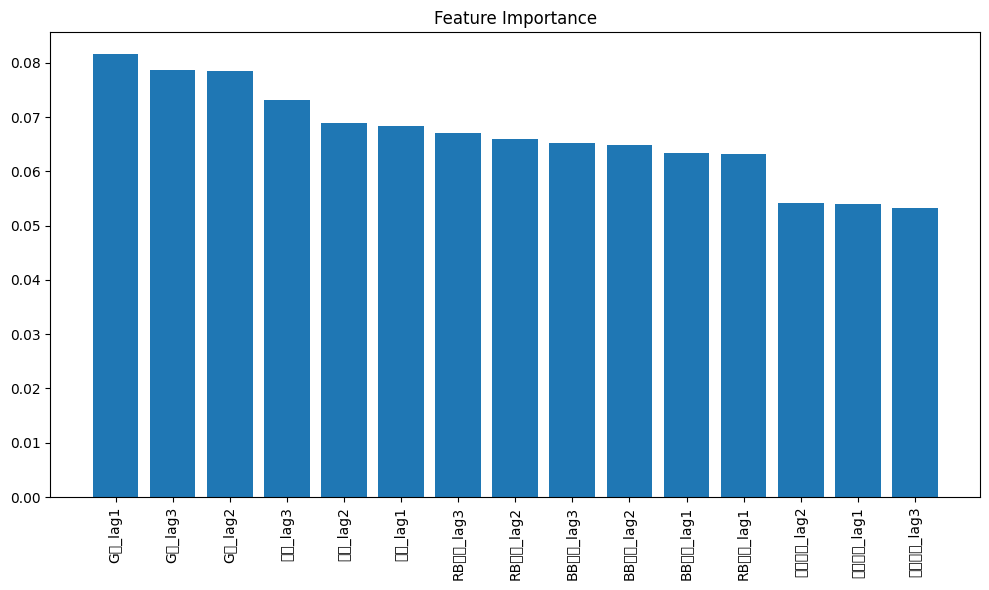

In [41]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(feature_cols)), importances[indices])
plt.xticks(range(len(feature_cols)), [feature_cols[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()
